In [1]:
import sys
sys.path.append("../")
import torch
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler,AutoencoderKL
from lora_diffusion import tune_lora_scale, patch_pipe
from PIL import Image
from z_dataset import z_Dataset
from torchvision import transforms
from visualization import jupyter_prompt_based_generation, only_text_prompt_generation, clip_evaluation_generation
import open_clip
from z_net import Image_adapter, Multimodal_adapter

model_id = "stabilityai/stable-diffusion-2-1-base"

with torch.no_grad():
    pipe = StableDiffusionPipeline.from_pretrained(model_id).to("cuda")
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    i2t_prompt_model,_,preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
    i2t_prompt_model = i2t_prompt_model.to("cuda")
    patch_pipe(pipe,
    "./output/clip_attention_img_adapter/checkpoint/lora_weight_e937_s7500.pt",
    patch_text=False,
    patch_ti=False,
    patch_unet=True,)
#     adapter = Image_adapter().to("cuda")
    adapter = Multimodal_adapter().to("cuda")
    info = torch.load("./output/clip_attention_img_adapter/checkpoint/lora_weight_e937_s7500.i2tp.pt")
    adapter.load_state_dict(info)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/chenhong/.conda/envs/diffusion/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


LoRA : Patching Unet


  0%|          | 0/50 [00:00<?, ?it/s]

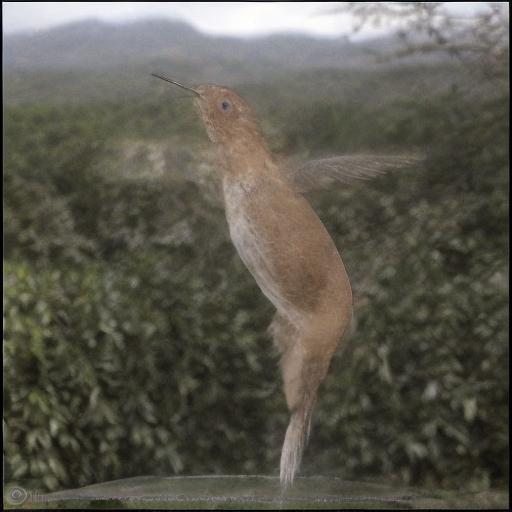

In [6]:
import numpy as np
prompt = "in the water"
img_resolution = 512
guidance = 0.0
img_weight = 0.8
ref_image = preprocess(Image.open("./training_data/images/bird2.jpg")).unsqueeze(0).to("cuda")

# ref_image = Image.open("./training_data/unseen_images/bike1.jpg").convert("RGB").resize((img_resolution, img_resolution))
#ref_image = np.zeros((3,img_resolution,img_resolution),dtype=np.float32)
gen_img = clip_evaluation_generation(pipe,i2t_prompt_model,adapter,prompt,ref_image, guidance, img_weight)
# gen_img = only_text_prompt_generation(pipe, prompt, guidance)
gen_img[0]